# Geolocalización mundoLibro

El objetivo es obtener las librerías, imprentas y otros establecimientos relacionados con el libro geolocalizados en la cuadrícula de Tomás López.
## Proceso mínimo
- Subir los datos como tabla alojada a ArcGis Online
- Unir los datos (muchos a uno) con los centroides de la cuadrícula de Tomás López (id: `5d5cce72838c418c9b3b4f232bd09c47`) 
- Con los datos unidos se pueden crear varias visualizaciones usando la resolución de la cuadrícula
    - visualización filtrando por tipos de tienda (hecho en AGOL)
    - identificación según género (hecho en AGOL)
    - visualización identificando los tipos que son imprenta y tienda.

### Bonus
- Duplicación del servicio para editarlo manualmente y mover los puntos a las calles (Proceso de aumento de calidad)


In [1]:
import arcgis
from arcgis.gis import GIS
import pandas as pd
from arcgis import features

In [2]:
env_path = "../.env"
with open(env_path) as f:
    env = {}
    for line in f:
        env_key, _val = line.split("=")
        env_value = _val.split("\n")[0]
        env[env_key] = env_value
aol_password = env['aol_key']
aol_username = env['aol_username']

In [3]:
gis = GIS("https://carcem.maps.arcgis.com/", aol_username, aol_password)

# Subir datos

In [7]:
csv_file = "mundolibro_sig/SIG-Tabla 1.csv"

In [8]:
csv_item = gis.content.add({}, csv_file)

In [9]:
csv_lyr = csv_item.publish(publish_parameters={'locationType':'none', 'type':'csv'})

In [13]:
csv_lyr

<Item title:"SIG-Tabla 1" type:Table Layer owner:greta_carcem>

In [16]:
lib_table_lay = csv_lyr.tables[0]

# Unir los datos a los centroides de tomas lopez
[ayuda función: Entidades de unión](https://developers.arcgis.com/python/api-reference/arcgis.features.summarize_data.html#arcgis.features.summarize_data.join_features)

In [17]:
for fld in lib_table_lay.properties.fields:
    print(fld.name)

Tipo
Nombre
Dirección
Referencia_completa_de_direcció
Año_ini_
Año_fin
Género
Fuente_
letra
Numero
coordenada
ObjectId


In [22]:
centroide_item = gis.content.get("5d5cce72838c418c9b3b4f232bd09c47")
centroid_flayer = centroide_item.layers[0]

In [24]:
for fld in centroid_flayer.properties.fields:
    print(fld.name)

OBJECTID
letra
numero
ORIG_FID
coordenada


In [27]:
# identificar el coste en créditos
features.summarize_data.join_features(target_layer = centroid_flayer, 
                                     join_layer = lib_table_lay,
                                     attribute_relationship = [{"targetField":"coordenada",
                                                                "operator":"equal",
                                                                "joinField":"coordenada"}],
                                     join_operation = "JoinOneToMany",
                                     output_name = "union_mundo_libro",
                                     estimate = True)

0.298

In [28]:
union_flayer = features.summarize_data.join_features(target_layer = centroid_flayer, 
                                     join_layer = lib_table_lay,
                                     attribute_relationship = [{"targetField":"coordenada",
                                                                "operator":"equal",
                                                                "joinField":"coordenada"}],
                                     join_operation = "JoinOneToMany",
                                     output_name = "union_mundo_libro",
                                     estimate = False)

In [29]:
union_flayer

<Item title:"union_mundo_libro" type:Feature Layer Collection owner:greta_carcem>

# Dupicar (clonar) servicio para futura edición (incrementar la calidad)

<Item title:"union_mundo_libro" type:Feature Layer Collection owner:greta_carcem>
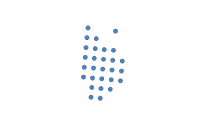

In [5]:
hosted_flyr = gis.content.get("a31e1fdeee954641bf19bb05a67fd618")
hosted_flyr

In [6]:
target = gis

In [8]:
cloned_flyr = target.content.clone_items(items=[hosted_flyr],
                                        owner="greta_carcem")

In [14]:
cloned_flyr[0].id

'a653206296524afca494ffae1cd2fb0f'

<Item title:"union_mundo_libro_para_Editar" type:Feature Layer Collection owner:greta_carcem>
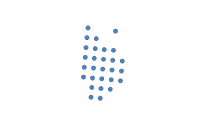

In [16]:
new_flyr = gis.content.get(cloned_flyr[0].id)
new_flyr #el nombre del item y las propiedades de edición se han cambiado via la web.